In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load and Setup Files

In [ ]:
import json
from pycocotools.coco import COCO
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

output_dir = '/content/drive/MyDrive/coco/'
image_dir = '/content/drive/MyDrive/coco/'
image_filename = 'img.png'
image_path = os.path.join(image_dir, image_filename)
image_loaded = cv2.imread(image_path)
data_output_path = image_dir

regions_path = '/content/drive/MyDrive/coco/segmentation_annotations_orig.json'
coco_annotation_file = regions_path
coco = COCO(regions_path)

category_ids = coco.getCatIds()
categories = coco.loadCats(category_ids)
category_names = [category['name'] for category in categories]

mirrored_segments_path = '/content/drive/MyDrive/coco/segmentations_mirrored.json'
coco_keypoints_norm_path = '/content/drive/MyDrive/coco/keypoints_normalized.json'
coco_segments_norm_path = '/content/drive/MyDrive/coco/segments_normalized.json'
mirrored_segments_path_normalized = '/content/drive/MyDrive/coco/segmentations_mirrored_normalized.json'


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


##MODIFICATION: PyCoco.ShowAnns()

In [ ]:
from pycocotools import mask as maskUtils
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np
# Create a subclass of COCO to override the showAnns function
class CustomCOCO(COCO):

  def showAnns(self, anns, draw_bbox=False, marker_size=4):
    """
    Display the specified annotations.
    :param anns (array of object): annotations to display
    :return: None
    """
    if len(anns) == 0:
        return 0
    if 'segmentation' in anns[0] or 'keypoints' in anns[0]:
        datasetType = 'instances'
    elif 'caption' in anns[0]:
        datasetType = 'captions'
    else:
        raise Exception('datasetType not supported')
    if datasetType == 'instances':
        ax = plt.gca()
        ax.set_autoscale_on(False)
        polygons = []
        color = []
        for ann in anns:
            c = (np.random.random((1, 3))*0.6+0.4).tolist()[0]
            if 'segmentation' in ann:
                if type(ann['segmentation']) == list:
                    # polygon
                    for seg in ann['segmentation']:
                        poly = np.array(seg).reshape((int(len(seg)/2), 2))
                        polygons.append(Polygon(poly))
                        color.append(c)
                else:
                    # mask
                    t = self.imgs[ann['image_id']]
                    if type(ann['segmentation']['counts']) == list:
                        rle = maskUtils.frPyObjects([ann['segmentation']], t['height'], t['width'])
                    else:
                        rle = [ann['segmentation']]
                    m = maskUtils.decode(rle)
                    img = np.ones( (m.shape[0], m.shape[1], 3) )
                    if ann['iscrowd'] == 1:
                        color_mask = np.array([2.0,166.0,101.0])/255
                    if ann['iscrowd'] == 0:
                        color_mask = np.random.random((1, 3)).tolist()[0]
                    for i in range(3):
                        img[:,:,i] = color_mask[i]
                    ax.imshow(np.dstack( (img, m*0.5) ))
            if 'keypoints' in ann and type(ann['keypoints']) == list:
                # turn skeleton into zero-based index
                sks = np.array(self.loadCats(ann['category_id'])[0]['skeleton'])-1
                kp = np.array(ann['keypoints'])
                x = kp[0::3]
                y = kp[1::3]
                v = kp[2::3]
                for sk in sks:
                    if np.all(v[sk]>0):
                        plt.plot(x[sk],y[sk], linewidth=3, color=c)
                plt.plot(x[v>0], y[v>0],'o',markersize=marker_size, markerfacecolor=c, markeredgecolor='k',markeredgewidth=2)
                plt.plot(x[v>1], y[v>1],'o',markersize=marker_size, markerfacecolor=c, markeredgecolor=c, markeredgewidth=2)

            if draw_bbox:
                [bbox_x, bbox_y, bbox_w, bbox_h] = ann['bbox']
                poly = [[bbox_x, bbox_y], [bbox_x, bbox_y+bbox_h], [bbox_x+bbox_w, bbox_y+bbox_h], [bbox_x+bbox_w, bbox_y]]
                np_poly = np.array(poly).reshape((4,2))
                polygons.append(Polygon(np_poly))
                color.append(c)

        p = PatchCollection(polygons, facecolor=color, linewidths=0, alpha=0.4)
        ax.add_collection(p)
        p = PatchCollection(polygons, facecolor='none', edgecolors=color, linewidths=2)
        ax.add_collection(p)
    elif datasetType == 'captions':
        for ann in anns:
            print(ann['caption'])

## Mirror Segmentation Annotations
*For segmentation files that are only annotated on one side of the object and need to be mirrored symmetrically.*

In [ ]:
import copy
import json
import numpy as np
from pycocotools import mask as mask_utils

def get_image_dimensions(image_id, images_data):
    """
    Retrieve the width and height of an image given its image ID.
    """
    for image in images_data:
        if image['id'] == image_id:
            return image['width'], image['height']
    raise ValueError(f"No image found with image_id: {image_id}")

def calculate_face_center(coco_data):
    """
    Calculates the center x-coordinate of the face by averaging key x-coordinates in the segmentation.
    """
    rightmost_x = -np.inf
    leftmost_x = np.inf
    for annotation in coco_data['annotations']:
        for segment in annotation['segmentation']:
            for idx in range(0, len(segment), 2):
                if segment[idx] > rightmost_x:
                    rightmost_x = segment[idx]
                if segment[idx] < leftmost_x:
                    leftmost_x = segment[idx]
    return (rightmost_x)   # The center of the face

def mirror_polygon_segmentation(annotation, image_width, new_id, center_x):
    """
    Mirror a polygon segmentation given the image width and a center x-coordinate for mirroring.
    """
    if not isinstance(annotation['segmentation'], list):
        return None

    mirrored_annotation = copy.deepcopy(annotation)
    mirrored_annotation['id'] = new_id

    # Mirror segmentation coordinates
    mirrored_segmentations = []
    for segment in mirrored_annotation['segmentation']:
        mirrored_segment = []
        for idx in range(len(segment)):
            if idx % 2 == 0:  # x-coordinate
                mirrored_segment.append(center_x + (center_x - segment[idx]))
            else:  # y-coordinate remains unchanged
                mirrored_segment.append(segment[idx])
        mirrored_segmentations.append(mirrored_segment)

    mirrored_annotation['segmentation'] = mirrored_segmentations

    # Update bounding box based on mirrored segmentation
    x_coords = [mirrored_segment[i] for segment in mirrored_segmentations for i in range(0, len(segment), 2)]
    y_coords = [mirrored_segment[i] for segment in mirrored_segmentations for i in range(1, len(segment), 2)]
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)
    mirrored_annotation['bbox'] = [x_min, y_min, x_max - x_min, y_max - y_min]

    return mirrored_annotation

def adjust_annotation_to_dimensions(annotation, original_width, original_height, target_width, target_height):
    """
    Adjust the segmentation and bounding box values to new target dimensions.
    """
    scale_x = target_width / original_width
    scale_y = target_height / original_height

    adjusted_annotation = copy.deepcopy(annotation)
    adjusted_segmentations = []

    # Adjust segmentation polygons
    for segment in adjusted_annotation['segmentation']:
        adjusted_segment = [
            coord * scale_x if i % 2 == 0 else coord * scale_y
            for i, coord in enumerate(segment)
        ]
        adjusted_segmentations.append(adjusted_segment)

    adjusted_annotation['segmentation'] = adjusted_segmentations

    # Adjust bounding box
    adjusted_bbox = [
        adjusted_annotation['bbox'][0] * scale_x,
        adjusted_annotation['bbox'][1] * scale_y,
        adjusted_annotation['bbox'][2] * scale_x,
        adjusted_annotation['bbox'][3] * scale_y
    ]
    adjusted_annotation['bbox'] = adjusted_bbox

    return adjusted_annotation

def mirror_segment_annotations(json_file, output_path, target_width=None, target_height=None):
    """
    Load the COCO annotations, normalize them if required, and mirror the segmentations.
    """
    with open(json_file, 'r') as file:
        coco_data = json.load(file)

    # If new dimensions are provided, adjust annotations to match those dimensions
    if target_width is not None and target_height is not None:
        for image in coco_data['images']:
            original_width, original_height = image['width'], image['height']
            if original_width != target_width or original_height != target_height:
                for annotation in coco_data['annotations']:
                    if annotation['image_id'] == image['id']:
                        adjusted_annotation = adjust_annotation_to_dimensions(
                            annotation, original_width, original_height, target_width, target_height
                        )
                        annotation.update(adjusted_annotation)
                image['width'] = target_width
                image['height'] = target_height

    # Generate new unique ids for the mirrored segments, continue from the maximum id in current dataset
    max_id = max(ann['id'] for ann in coco_data['annotations'])

    # Calculate the center of the face for mirroring
    face_center_x = calculate_face_center(coco_data)

    # Mirror segmentations
    mirrored_annotations = []
    for annotation in coco_data['annotations']:
        new_id = max_id + 1
        max_id += 1
        image_width, _ = get_image_dimensions(annotation['image_id'], coco_data['images'])
        mirrored_annotation = mirror_polygon_segmentation(annotation, image_width, new_id, face_center_x)
        if mirrored_annotation:
            mirrored_annotations.append(mirrored_annotation)

    # Add mirrored annotations to the original dataset
    coco_data['annotations'].extend(mirrored_annotations)

    # Save the output
    output_path = f"{output_path}segmentations_mirrored.json"
    with open(output_path, "w") as output_file:
        json.dump(coco_data, output_file, indent=4)
    print(f"Mirrored COCO JSON saved to {output_path}")
    return output_path

In [ ]:
 mirror_segment_annotations(regions_path, data_output_path)

Mirrored COCO JSON saved to /content/drive/MyDrive/coco/segmentations_mirrored.json


'/content/drive/MyDrive/coco/segmentations_mirrored.json'

## Helper functions

In [ ]:

def load_coco_objects(json_paths):
    coco_objects = []
    for path in json_paths:
        if path.lower().endswith('.json'):
            coco_objects.append(COCO(path))
    return coco_objects

def safe_showAnns(coco, anns):
    for ann in anns:
        category = coco.loadCats(ann['category_id'])[0]
        if 'skeleton' not in category:
            category['skeleton'] = []
    CustomCOCO.showAnns(coco, anns)
   # coco.showAnns(anns)

----
## Convert CVAT.Images xml format to JSON

In [ ]:
import json
import xml.etree.ElementTree as ET
from datetime import datetime

def convert_cvat_xml_to_json(cvat_xml_path, output_coco_path):
    # Parse the CVAT XML file
    tree = ET.parse(cvat_xml_path)
    root = tree.getroot()

    # Initialize COCO structure
    coco_data = {
        "info": {
            "year": datetime.now().year,
            "version": "1.0",
            "description": "COCO format with point annotations and labels",
            "date_created": datetime.now().isoformat()
        },
        "licenses": [],
        "images": [],
        "annotations": [],
        "categories": []
    }

    # Map to store categories and their IDs
    categories = {}
    category_id = 1

    image_id = 1
    annotation_id = 1

    for image_tag in root.findall("image"):
        # Add image information
        image_name = image_tag.get("name")
        image_width = int(image_tag.get("width"))
        image_height = int(image_tag.get("height"))

        coco_data["images"].append({
            "id": image_id,
            "file_name": image_name,
            "width": image_width,
            "height": image_height
        })

        # Process points for the current image
        for point_tag in image_tag.findall("points"):
            # Extract label and create category if it doesn't exist
            label = point_tag.get("label")
            if label not in categories:
                categories[label] = category_id
                coco_data["categories"].append({
                    "id": category_id,
                    "name": label,
                    "supercategory": "object"
                })
                category_id += 1

            # Get point coordinates and bounding box
            points_str = point_tag.get("points")
            points = list(map(float, points_str.split(',')))
            x_coords = points[::2]
            y_coords = points[1::2]
            bbox = [
                min(x_coords),
                min(y_coords),
                max(x_coords) - min(x_coords),
                max(y_coords) - min(y_coords)
            ]

            # Prepare keypoints with visibility flag
            keypoints = []
            for x, y in zip(x_coords, y_coords):
                keypoints.extend([x, y, 2])  # visibility set to 2 (visible)

            # Collect additional attributes (if any)
            attributes = {}
            for attr in point_tag.findall("attribute"):
                attr_name = attr.get("name")
                attr_value = attr.text
                attributes[attr_name] = attr_value

            # Add annotation with attributes
            coco_annotation = {
                "id": annotation_id,
                "image_id": image_id,
                "category_id": categories[label],
                "keypoints": keypoints,
                "num_keypoints": len(x_coords),
                "bbox": bbox,
                "area": 1,  # Set to 1 for single points
                "iscrowd": 0,
                "attributes": attributes,  # Store attributes in annotation
            }
            coco_data["annotations"].append(coco_annotation)
            annotation_id += 1

        image_id += 1

    # Save the COCO formatted data
    with open(output_coco_path, 'w') as f:
        json.dump(coco_data, f, indent=4)

    print(f"Conversion complete. COCO format data saved to {output_coco_path}")


In [ ]:
json_zero_to_fifty='/content/drive/MyDrive/coco/json/0to50.json'
json_fiftyone_to_seventy='/content/drive/MyDrive/coco/json/51to70.json'
json_seventyone_to_onefifty='/content/drive/MyDrive/coco/json/71to150.json'
json_onefiftyone_to_twohundred='/content/drive/MyDrive/coco/json/151to200.json'
json_twohundredone_to_twofifty='/content/drive/MyDrive/coco/json/201to250.json'
json_twofiftyone_to_threehundred='/content/drive/MyDrive/coco/json/251to300.json'
json_threehundredone_to_threefifty='/content/drive/MyDrive/coco/json/301to350.json'
json_threefiftyone_to_threeninetynine='/content/drive/MyDrive/coco/json/351to399.json'
json_fourhundred_to_fourseventyseven='/content/drive/MyDrive/coco/json/400to477.json'

In [ ]:
convert_cvat_xml_to_json('/content/drive/MyDrive/coco/xml/0to50.xml', json_zero_to_fifty)
convert_cvat_xml_to_json('/content/drive/MyDrive/coco/xml/51to70.xml', json_fiftyone_to_seventy)
convert_cvat_xml_to_json('/content/drive/MyDrive/coco/xml/71to150.xml', json_seventyone_to_onefifty)
convert_cvat_xml_to_json('/content/drive/MyDrive/coco/xml/151to200.xml', json_onefiftyone_to_twohundred)
convert_cvat_xml_to_json('/content/drive/MyDrive/coco/xml/201to250.xml', json_twohundredone_to_twofifty)
convert_cvat_xml_to_json('/content/drive/MyDrive/coco/xml/251to300.xml', json_twofiftyone_to_threehundred)
convert_cvat_xml_to_json('/content/drive/MyDrive/coco/xml/301to350.xml', json_threehundredone_to_threefifty)
convert_cvat_xml_to_json('/content/drive/MyDrive/coco/xml/351to399.xml', json_threefiftyone_to_threeninetynine)
convert_cvat_xml_to_json('/content/drive/MyDrive/coco/xml/400to477.xml', json_fourhundred_to_fourseventyseven)

Conversion complete. COCO format data saved to /content/drive/MyDrive/coco/json/0to50.json
Conversion complete. COCO format data saved to /content/drive/MyDrive/coco/json/51to70.json
Conversion complete. COCO format data saved to /content/drive/MyDrive/coco/json/71to150.json
Conversion complete. COCO format data saved to /content/drive/MyDrive/coco/json/151to200.json
Conversion complete. COCO format data saved to /content/drive/MyDrive/coco/json/201to250.json
Conversion complete. COCO format data saved to /content/drive/MyDrive/coco/json/251to300.json
Conversion complete. COCO format data saved to /content/drive/MyDrive/coco/json/301to350.json
Conversion complete. COCO format data saved to /content/drive/MyDrive/coco/json/351to399.json
Conversion complete. COCO format data saved to /content/drive/MyDrive/coco/json/400to477.json


In [ ]:
# Make an array of the json file paths (not loaded)
json_landmark_annotations = [
    json_zero_to_fifty,
    json_fiftyone_to_seventy,
    json_seventyone_to_onefifty,
    json_onefiftyone_to_twohundred,
    json_twohundredone_to_twofifty,
    json_twofiftyone_to_threehundred,
    json_threehundredone_to_threefifty,
    json_threefiftyone_to_threeninetynine,
    json_fourhundred_to_fourseventyseven
]

## Change image file_name for COCO if using different image

In [ ]:
import json
# Change the image name in the json files if using a different image for coco.
def change_image_filename(annotation_file, new_name):
    with open(annotation_file, 'r') as f:
        data = json.load(f)
    for img in data['images']:
        original_name = img['file_name']
        img['file_name'] = new_name
    with open(annotation_file, 'w') as f:
        json.dump(data, f, indent=4)
    print(f"Updated json annotation's image file_name to {new_name} in '{annotation_file}'.")

In [ ]:
for each in json_landmark_annotations:
  change_image_filename(each, 'img.png')
change_image_filename(regions_path, 'img.png')

Updated json annotation's image file_name to img.png in '/content/drive/MyDrive/coco/json/0to50.json'.
Updated json annotation's image file_name to img.png in '/content/drive/MyDrive/coco/json/51to70.json'.
Updated json annotation's image file_name to img.png in '/content/drive/MyDrive/coco/json/71to150.json'.
Updated json annotation's image file_name to img.png in '/content/drive/MyDrive/coco/json/151to200.json'.
Updated json annotation's image file_name to img.png in '/content/drive/MyDrive/coco/json/201to250.json'.
Updated json annotation's image file_name to img.png in '/content/drive/MyDrive/coco/json/251to300.json'.
Updated json annotation's image file_name to img.png in '/content/drive/MyDrive/coco/json/301to350.json'.
Updated json annotation's image file_name to img.png in '/content/drive/MyDrive/coco/json/351to399.json'.
Updated json annotation's image file_name to img.png in '/content/drive/MyDrive/coco/json/400to477.json'.
Updated json annotation's image file_name to img.png

----
# Load into Pandas DF
----

## COCOPANDAS UTILITIES

In [ ]:
import json
import pandas as pd

"""
Class CocoPandas provides modularity in data processing COCO-related data to simplify import of data and re-exporting out to COCO JSON files.
'source' attribute is be used as an identifier for separate COCO JSON files combined into one dataframe incase they need to have calculations depending on their original image dimensions.
"""
class CocoPandas():
    def __init__(self, file_path, source=""):
        self.file_path = file_path
        self.coco_json = None
        self.annotations_df = pd.DataFrame()
        self.images_df = pd.DataFrame()
        self.categories_df = pd.DataFrame()
        self.normalized_df = pd.DataFrame()
        self.rescaled_df = pd.DataFrame()
        self.source = source
        self.attribute_names_list = []

        self.load_coco_json_as_dataframe()
        ann_file_name = os.path.basename(self.file_path)
        self.ann_file_name = os.path.splitext(ann_file_name)[0]

    def clone(self):
        return copy.deepcopy(self)

    def load_coco_json_as_dataframe(self):
        """
        Preprocess and load the COCO JSON file into DataFrames.
        """
        with open(self.file_path, 'r') as file:
            print(f"Loading COCO JSON from {self.file_path}")
            coco_data = json.load(file)

        self.annotations_df = pd.DataFrame(coco_data["annotations"])
        self.categories_df = pd.DataFrame(coco_data["categories"]).drop_duplicates(subset=['name'])
        self.images_df = pd.DataFrame(coco_data["images"])[['id', 'width', 'height']]

        self.annotations_df['id'] = range(1, len(self.annotations_df) + 1)
        self.images_df['file_name'] = coco_data['file_name'] if "file_name" in coco_data["images"] else print("No image file_name was found.")
        self.categories_df['category_id'] = self.categories_df['id']
        self.annotations_df = self.annotations_df.merge(self.categories_df[['category_id', 'name']], on='category_id', how='left')

        self.annotations_df['source'] = self.source
        self.images_df['source'] = self.source
        self.categories_df['source'] = self.source

        if 'attributes' in self.annotations_df.columns:
            attributes_df = pd.json_normalize(self.annotations_df['attributes'])
            self.attribute_names_list = attributes_df.columns.tolist()
            self.annotations_df = pd.concat([self.annotations_df, attributes_df], axis=1)
            self.annotations_df = self.annotations_df.drop(columns=["attributes"])
            print(f"Attributes found in COCO file: {self.attribute_names_list}")
        else:
            print("No attributes found in COCO file.")

        if 'keypoints' in self.annotations_df.columns:
            self.separate_keypoints()
        else:
            print("No keypoints found in COCO file.")

        if 'segmentation' not in self.annotations_df.columns:
            print("No segmentation found in COCO file.")


    def separate_keypoints(self):
        """
        Separate the 'keypoints' column into individual columns ('x', 'y', 'visibility') for each keypoint.
        """
        if "x" in self.annotations_df.columns and "y" in self.annotations_df.columns:
            self.annotations_df = self.annotations_df.drop(columns=["x"])
            self.annotations_df = self.annotations_df.drop(columns=["y"])
        def explode(keypoints):
            keypoints_dict = {}
            for i in range(0, len(keypoints), 3):
                keypoints_dict["x"] = keypoints[i]
                keypoints_dict["y"] = keypoints[i + 1]
                keypoints_dict["visibility"] = keypoints[i + 2]
            return pd.Series(keypoints_dict)
        keypoints_df = self.annotations_df["keypoints"].apply(explode)
        self.annotations_df = pd.concat([self.annotations_df, keypoints_df], axis=1)
        self.annotations_df = self.annotations_df.drop(columns=["keypoints"])


    def combine_keypoints(self, dataframe, drop_cols=False):
        """
        Combine 'x', 'y', 'visibility' columns (if exists) into a COCO 'keypoints' column.
        - Creates a 'keypoints' column in the COCO format.
        - Optionally drops the individual 'x', 'y', and 'visibility' columns to clean up the DataFrame.
        """
        if 'x' not in dataframe.columns or 'y' not in dataframe.columns or 'visibility' not in dataframe.columns:
            print("No 'x', 'y', or 'visibility' columns found in the DataFrame.")
            return dataframe
        def combine(row):
            keypoints = []
            keypoints.extend([row["x"], row["y"], row["visibility"]])
            return keypoints

        dataframe['keypoints'] = dataframe.apply(combine, axis=1)
        dataframe = dataframe.drop(columns=["x", "y", "visibility"])
        if 'segmentation' in dataframe.columns:
            dataframe = dataframe.drop(columns=["segmentation"])
        return dataframe


    def compute_uniform_normalized_coordinates(self):
        """
        Normalize the dataframe uniformly incase there are keypoint data in the dataframe sourced by different image dimensions.
        """
        if "x" not in self.annotations_df.columns and "y" not in self.annotations_df.columns:
            print("No 'x' or 'y' columns found in the annotations DataFrame.")
        else:
            rescaler = KeypointRescalar(self.annotations_df, self.images_df)
            rescaler.normalize_coordinates()
            self.normalized_df = rescaler.get_normalized_df()
            print("Normalized keypoints in the annotations DataFrame.")

        if "segmentation" in self.annotations_df.columns:
            rescaler = SegmentationRescaler(self.annotations_df, self.images_df)
            rescaler.normalize_coordinates()
            self.normalized_df = rescaler.get_normalized_df()
            print("Normalized segmentation in the annotations DataFrame.")

        self.images_df = pd.DataFrame({'id': [1], 'width': [1], 'height': [1]})


    def rescale_to_size(self, target_width, target_height):
        """
        Rescale the normalized coordinates and bounding boxes to fit into a new bounding box size.
        Stores it into a new rescaled dataframe "rescaled_df"
        :param target_width: The width of the new bounding box.
        :param target_height: The height of the new bounding box.
        """
        if self.normalized_df is None:
            raise ValueError("Normalization has not been performed yet. Call normalize_coordinates() first.")
        def rescale_polygon(polygon, original_width, original_height, target_width, target_height):
           return [(coord * target_width if i % 2 == 0 else coord * target_height) for i, coord in enumerate(polygon)]

        def rescale_bbox(bbox, target_width, target_height):
            return [bbox[0] * target_width, bbox[1] * target_height,  bbox[2] * target_width, bbox[3] * target_height ]

        if self.normalized_df is None:
            raise ValueError("Normalization has not been performed yet. Call normalize_coordinates() first.")

        rescaled_df = self.normalized_df.copy()

        if {'x', 'y', 'visibility'}.issubset(self.rescaled_df.columns):
            rescaled_df['x'] = self.rescaled_df['x'] * target_width
            rescaled_df['y'] = self.rescaled_df['y'] * target_height

        if {'segmentation'}.issubset(self.rescaled_df.columns):
            rescaled_df['segmentation'] = rescaled_df['segmentation'].apply(
            lambda seg_list: [rescale_polygon(polygon, target_width, target_height) for polygon in seg_list])

        rescaled_df['bbox'] = rescaled_df['bbox'].apply(lambda bbox: rescale_bbox(bbox, target_width, target_height))
        print(f"Rescaled to {target_width}x{target_height}")


    def print_missing_points(self,df, column_name, start=0, end=477):
        """
        Return any missing point values in a given range.
        """
        df[column_name] = df[column_name].astype(int)
        data = set(df[column_name])
        missing_numbers = list(set(range(start, end)) - data)
        print(f"Missing {len(missing_numbers)} Point Labels: {missing_numbers}")


    def export_annotations_as_coco(self, output_dir, suffix=""):
        """
        Function to export the DataFrame back to COCO format.
        """

        def process_export(annotations_df, images_df, categories_df,  attribute_names_list):

            # Ensure the input data are DataFrames
            if isinstance(annotations_df, list):
                annotations_df = pd.DataFrame(annotations_df)
            if isinstance(images_df, list):
                images_df = pd.DataFrame(images_df)
            if isinstance(categories_df, list):
                categories_df = pd.DataFrame(categories_df)

            # Check for None or empty DataFrames
            if annotations_df is None or annotations_df.empty:
                print(f"Warning: annotations_df is empty or None.")
                return None
            if images_df is None or images_df.empty:
                print(f"Warning: images_df for is empty or None.")
                return None
            if categories_df is None or categories_df.empty:
                print(f"Warning: categories_df for is empty or None.")
                return None

            # Define standard COCO columns
            attributes = attribute_names_list
            coco_column_formats = ['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox', 'iscrowd', 'keypoints']
            coco_image_formats = ['id', 'width', 'height', 'file_name', 'license', 'flickr_url', 'coco_url', 'date_captured']
            coco_category_formats = ['id', 'name', 'supercategory']

            # Add any attribute columns found
            coco_column_formats.extend(attributes)

            # Ensure all necessary columns exist in annotations, images, and categories DataFrames
            for col in coco_column_formats:
                if col not in annotations_df.columns:
                    annotations_df[col] = ""

            for col in coco_image_formats:
                if col not in images_df.columns:
                    images_df[col] = ""

            for col in coco_category_formats:
                if col not in categories_df.columns:
                    categories_df[col] = ""

            if 'keypoints' in annotations_df.columns:
                annotations_df = self.combine_keypoints(annotations_df)

            # Drop duplicate columns
            annotations_df = annotations_df.loc[:, ~annotations_df.columns.duplicated()]
            images_df = images_df.loc[:, ~images_df.columns.duplicated()]
            categories_df = categories_df.loc[:, ~categories_df.columns.duplicated()]

            # Drop any extra columns that are not part of the COCO format
            annotations_df = annotations_df[[col for col in coco_column_formats if col in annotations_df.columns]]
            images_df = images_df[[col for col in coco_image_formats if col in images_df.columns]]
            categories_df = categories_df[[col for col in coco_category_formats if col in categories_df.columns]]

            # Drop 'source' column if it exists
            if 'source' in annotations_df.columns:
                annotations_df.drop(columns=['source'], inplace=True)

            annotations_df['id'] = range(1, len(self.annotations_df) + 1)
            images_df['id'] = range(1, len(self.images_df) + 1)

            # Build COCO JSON structure
            coco_json = {
                "images": images_df.to_dict(orient="records"),
                "annotations": annotations_df.to_dict(orient='records'),
                "categories": categories_df.to_dict(orient="records")
            }

            return coco_json

        # Process both normalized and rescaled DataFrames
        norm_df = self.normalized_df.copy() if hasattr(self, 'normalized_df') and self.normalized_df is not None else None
        norm_img_df = self.images_df.copy()
        norm_cat_df = self.categories_df.copy()

        rescaled_df = self.rescaled_df.copy() if hasattr(self, 'rescaled_df') and self.rescaled_df is not None else None
        rescaled_img_df = self.images_df.copy()
        rescaled_cat_df = self.categories_df.copy()

        # Generate and export COCO JSON for normalized annotations
        if norm_df is not None:
            coco_json_norm = process_export(norm_df, norm_img_df, norm_cat_df, self.attribute_names_list)
            if coco_json_norm:
                export_file = f"{output_dir}{self.ann_file_name}_normalized.json"
                with open(export_file, "w") as file:
                    json.dump(coco_json_norm, file, indent=4)
                print(f"Exported to COCO format: {export_file}")
"""
        # Generate and export COCO JSON for rescaled annotations
        if rescaled_df is not None:
            coco_json_rescaled = process_export(rescaled_df, rescaled_img_df, rescaled_cat_df, self.attribute_names_list, "rescaled")
            if coco_json_rescaled:
                export_file = f"{output_dir}{suffix}_rescaled.json"
                with open(export_file, "w") as file:
                    json.dump(coco_json_rescaled, file, indent=4)
                print(f"Exported to COCO format: {export_file}")
"""
def combine_coco_pandas(df1, df2):
    """
    Concatenates two CocoPandas objects.
    """
    df1.annotations_df = pd.concat([df1.annotations_df, df2.annotations_df], ignore_index=False,axis=0)
    df1.images_df = pd.concat([df1.images_df, df2.images_df], ignore_index=False,axis=0)
    df1.categories_df = pd.concat([df1.categories_df, df2.categories_df], ignore_index=False,axis=0)
    return df1

## Keypoint Rescalar

In [ ]:
import pandas as pd

class KeypointRescalar:
    def __init__(self, annotations_df, images_df):
        """
        Initialize with annotations DataFrame and image dimensions DataFrame.

        :param annotations_df: DataFrame containing 'x', 'y', 'source', and 'bbox'.
        :param images_df: DataFrame containing 'source', 'width', and 'height'.
        """
        self.annotations_df = annotations_df
        self.images_df = images_df
        self.normalized_df = None


    def normalize_coordinates(self):
        """
        Normalize x and y coordinates and bounding boxes using respective image dimensions from images_df.
        The result is saved in `self.normalized_df`.
        """
        def normalize_bbox(bbox, width, height):
            return [
                bbox[0] / width,
                bbox[1] / height,
                bbox[2] / width,
                bbox[3] / height]

        def update_normal_bbox(bbox):
            x_min_norm = (bbox[0] - min_x) / (max_x - min_x)
            y_min_norm = (bbox[1] - min_y) / (max_y - min_y)
            width_norm = bbox[2] / (max_x - min_x)
            height_norm = bbox[3] / (max_y - min_y)
            return [x_min_norm, y_min_norm, width_norm, height_norm]

        # Merge annotations with image dimensions on the 'source' column
        merged_df = self.annotations_df.merge(
            self.images_df,
            on='source',
            how='left',
            suffixes=('', '_image'))

        # Check if there are any missing width or height values
        if merged_df['width'].isnull().any() or merged_df['height'].isnull().any():
            raise ValueError("Some sources in annotations_df are missing corresponding dimensions in images_df.")

        # Normalize x, y, and bbox against their original sourced image dimensions
        normalized_df = merged_df.copy()
        normalized_df['x'] = normalized_df['x'] / normalized_df['width']
        normalized_df['y'] = normalized_df['y'] / normalized_df['height']
        normalized_df['bbox'] = normalized_df.apply(lambda row: normalize_bbox(row['bbox'], row['width'], row['height']), axis=1)

        display(normalized_df)

        """
        # Calculate the overall bounding box for the entire collection of keypoints
        min_x = normalized_df['x'].min()
        max_x = normalized_df['x'].max()
        min_y = normalized_df['y'].min()
        max_y = normalized_df['y'].max()

        # Normalize keypoints against the bounding box of the entire collection
        normalized_df['x'] = (normalized_df['x'] - min_x) / (max_x - min_x)
        normalized_df['y'] = (normalized_df['y'] - min_y) / (max_y - min_y)
        normalized_df['bbox'] = normalized_df['bbox'].apply(update_normal_bbox)
        """
        # Drop unnecessary columns
        self.normalized_df = normalized_df.drop(columns=['width', 'height','source'])  # Drop the original bbox
        display(normalized_df)

    def get_normalized_df(self):
        """
        Get the normalized DataFrame with the original columns retained and all normalized calculation columns removed.
        :return: DataFrame containing the normalized annotations.
        """
        if self.normalized_df is None:
            raise ValueError("Normalization has not been performed yet. Call normalize_coordinates() first.")
        return self.normalized_df


    @staticmethod
    def denormalize_coordinates(normalized_df, target_width, target_height):
        """
        Denormalize normalized x, y, and bbox values into absolute coordinates for a specific target dimension.

        :param normalized_df: DataFrame containing normalized coordinates.
        :param target_width: The target width for denormalization.
        :param target_height: The target height for denormalization.
        :return: DataFrame with absolute coordinates added.
        """
        denormalized_df = normalized_df.copy()
        denormalized_df['x_absolute'] = denormalized_df['x'] * target_width
        denormalized_df['y_absolute'] = denormalized_df['y'] * target_height

        def denormalize_bbox(bbox, target_width, target_height):
            return [
                bbox[0] * target_width,  # Denormalize x
                bbox[1] * target_height, # Denormalize y
                bbox[2] * target_width,  # Denormalize width
                bbox[3] * target_height]

        denormalized_df['bbox_absolute'] = denormalized_df['bbox'].apply(
            lambda bbox: denormalize_bbox(bbox, target_width, target_height) )

        return denormalized_df


## Segmentation Rescalar

In [ ]:
import pandas as pd

class SegmentationRescaler:
    def __init__(self, annotations_df, images_df):
        """
        Initialize with annotations DataFrame and image dimensions DataFrame.

        :param annotations_df: DataFrame containing 'source' and 'segmentation'.
                               'segmentation' contains polygons as lists of coordinates [[x1, y1, x2, y2, ...], ...].
        :param images_df: DataFrame containing 'source', 'width', and 'height'.
        """
        self.annotations_df = annotations_df
        self.images_df = images_df
        self.normalized_df = None

    def normalize_coordinates(self):
        """
        Normalize segmentation polygons using respective image dimensions from images_df,
        followed by a global normalization.
        """
        # Helper functions for normalization
        def calculate_area_from_polygons(polygon):
            x = polygon[0::2]  # x-coordinates
            y = polygon[1::2]  # y-coordinates
            return 0.5 * abs(sum(x[i] * y[i + 1] - y[i] * x[i + 1] for i in range(-1, len(x) - 1)))

        def normalize_polygon(polygon, width, height):
            return [(coord / width if i % 2 == 0 else coord / height) for i, coord in enumerate(polygon)]

        def normalize_bbox(bbox, width, height):
            return [
                bbox[0] / width,
                bbox[1] / height,
                bbox[2] / width,
                bbox[3] / height ]

        def normalize_polygon_globally(polygon, min_x, max_x, min_y, max_y):
            return [(coord - min_x) / (max_x - min_x) if i % 2 == 0 else (coord - min_y) / (max_y - min_y)
                    for i, coord in enumerate(polygon)]

        def update_bbox_globally(bbox, min_x, max_x, min_y, max_y):
            x_min_norm = (bbox[0] - min_x) / (max_x - min_x)
            y_min_norm = (bbox[1] - min_y) / (max_y - min_y)
            width_norm = bbox[2] / (max_x - min_x)
            height_norm = bbox[3] / (max_y - min_y)
            return [x_min_norm, y_min_norm, width_norm, height_norm]

        # Merge annotations with image dimensions on the 'source' column
        merged_df = self.annotations_df.merge(
            self.images_df,
            on='source',
            how='left',
            suffixes=('', '_image'))

        # Check if there are any missing width or height values
        if merged_df['width'].isnull().any() or merged_df['height'].isnull().any():
            raise ValueError("Some sources in annotations_df are missing corresponding dimensions in images_df.")

        normalized_df = merged_df.copy()

        # Step 1: Image-Level Normalization
        # Normalize polygons
        normalized_df['segmentation'] = normalized_df.apply(
            lambda row: [normalize_polygon(polygon, row['width'], row['height']) for polygon in row['segmentation']],
            axis=1)

        # Normalize bbox if it exists
        if 'bbox' in normalized_df:
            normalized_df['bbox'] = normalized_df.apply(
                lambda row: normalize_bbox(row['bbox'], row['width'], row['height']),axis=1)

        # Remove old area column and recalculate the area using normalized polygons
        if 'area' in normalized_df:
            normalized_df.drop(columns=['area'], inplace=True)
        normalized_df['area'] = normalized_df['segmentation'].apply(
            lambda seg: sum(calculate_area_from_polygons(polygon) for polygon in seg))

        """
        display(normalized_df)
        # Step 2: Global Normalization (Face-Level/Collection-Level)
        # Calculate global min and max for x and y across all polygons
        all_x = []
        all_y = []
        for segmentations in normalized_df['segmentation']:
            for polygon in segmentations:
                all_x.extend(polygon[0::2])
                all_y.extend(polygon[1::2])
        min_x, max_x = min(all_x), max(all_x)
        min_y, max_y = min(all_y), max(all_y)

        # Apply global normalization to polygons
        normalized_df['segmentation'] = normalized_df['segmentation'].apply(
            lambda seg: [normalize_polygon_globally(polygon, min_x, max_x, min_y, max_y) for polygon in seg])

        # Update bbox to reflect global normalization if it exists
        if 'bbox' in normalized_df:
            normalized_df['bbox'] = normalized_df['bbox'].apply(
                lambda bbox: update_bbox_globally(bbox, min_x, max_x, min_y, max_y))

        # Update area to reflect global normalization
        normalized_df['area'] = normalized_df['segmentation'].apply(
            lambda seg: sum(calculate_area_from_polygons(polygon) for polygon in seg))
        """
        # Drop unnecessary columns
        self.normalized_df = normalized_df.drop(columns=['width', 'height','source'])
        display(self.normalized_df)
    def get_normalized_df(self):
        """
        Get the normalized DataFrame with the original columns retained and all normalized calculation columns removed.
        :return: DataFrame containing the normalized annotations.
        """
        if self.normalized_df is None:
            raise ValueError("Normalization has not been performed yet. Call normalize_coordinates() first.")
        return self.normalized_df


----
# Calculations
----

### Calculation: Keypoint Annotation

In [ ]:
keypoints_df = CocoPandas(json_landmark_annotations[0],0)
keypoints_df.ann_file_name = "keypoints"
i = 1
for i in range(1,len(json_landmark_annotations)):
    combine_coco_pandas(keypoints_df, CocoPandas(json_landmark_annotations[i], i))
    i += 1

Loading COCO JSON from /content/drive/MyDrive/coco/json/0to50.json
No image file_name was found.
Attributes found in COCO file: ['region', 'side', 'point', 'x', 'y', 'z', 'injection_name', 'injection_point', 'area']
No segmentation found in COCO file.
Loading COCO JSON from /content/drive/MyDrive/coco/json/51to70.json
No image file_name was found.
Attributes found in COCO file: ['region', 'side', 'point', 'x', 'y', 'z', 'injection_name', 'injection_point', 'area']
No segmentation found in COCO file.
Loading COCO JSON from /content/drive/MyDrive/coco/json/71to150.json
No image file_name was found.
Attributes found in COCO file: ['region', 'side', 'point', 'x', 'y', 'z', 'injection_name', 'injection_point', 'area']
No segmentation found in COCO file.
Loading COCO JSON from /content/drive/MyDrive/coco/json/151to200.json
No image file_name was found.
Attributes found in COCO file: ['region', 'side', 'point', 'x', 'y', 'z', 'injection_name', 'injection_point', 'area']
No segmentation found 

### Keypoint Object Normalization

In [ ]:
keypoints_df.compute_uniform_normalized_coordinates()

,id,image_id,category_id,num_keypoints,bbox,area,iscrowd,name,source,region,...,injection_name,injection_point,area,x,y,visibility,id_image,width,height,file_name
0,1,1,1,1,"[0.492109375, 0.716357421875, 0.0, 0.0]",1,0,landmark,0,cupids_bow,...,None,false,eye,0.492109,0.716357,2.0,1,1024,1024,None
1,2,1,1,1,"[0.340966796875, 0.405107421875, 0.0, 0.0]",1,0,landmark,0,orbiculi_pelperbal,...,None,false,eye,0.340967,0.405107,2.0,1,1024,1024,None
2,3,1,1,1,"[0.375537109375, 0.408037109375, 0.0, 0.0]",1,0,landmark,0,orbiculi_pelperbal,...,None,false,eye,0.375537,0.408037,2.0,1,1024,1024,None
3,4,1,1,1,"[0.303828125, 0.44912109375, 0.0, 0.0]",1,0,landmark,0,lateral_palpebral_ligament,...,None,false,eye,0.303828,0.449121,2.0,1,1024,1024,None
4,5,1,1,1,"[0.2844921875, 0.48525390625, 0.0, 0.0]",1,0,landmark,0,orbital_oculi,...,None,false,eye,0.284492,0.485254,2.0,1,1024,1024,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,74,1,1,1,"[0.331640625, 0.442646484375, 0.0, 0.0]",1,0,landmark,8,pupil,...,None,false,eye,0.331641,0.442646,2.0,1,1024,1024,None
474,75,1,1,1,"[0.3596484375, 0.442646484375, 0.0, 0.0]",1,0,landmark,8,pupil,...,None,false,eye,0.359648,0.442646,2.0,1,1024,1024,None
475,76,1,1,1,"[0.388134765625, 0.442880859375, 0.0, 0.0]",1,0,landmark,8,pupil,...,None,false,eye,0.388135,0.442881,2.0,1,1024,1024,None
476,77,1,1,1,"[0.779267578125, 0.5223046875, 0.0, 0.0]",1,0,landmark,8,zygomaticus_major,...,None,false,masseter,0.779268,0.522305,2.0,1,1024,1024,None


,id,image_id,category_id,num_keypoints,bbox,area,iscrowd,name,source,region,...,injection_name,injection_point,area,x,y,visibility,id_image,width,height,file_name
0,1,1,1,1,"[0.492109375, 0.716357421875, 0.0, 0.0]",1,0,landmark,0,cupids_bow,...,None,false,eye,0.492109,0.716357,2.0,1,1024,1024,None
1,2,1,1,1,"[0.340966796875, 0.405107421875, 0.0, 0.0]",1,0,landmark,0,orbiculi_pelperbal,...,None,false,eye,0.340967,0.405107,2.0,1,1024,1024,None
2,3,1,1,1,"[0.375537109375, 0.408037109375, 0.0, 0.0]",1,0,landmark,0,orbiculi_pelperbal,...,None,false,eye,0.375537,0.408037,2.0,1,1024,1024,None
3,4,1,1,1,"[0.303828125, 0.44912109375, 0.0, 0.0]",1,0,landmark,0,lateral_palpebral_ligament,...,None,false,eye,0.303828,0.449121,2.0,1,1024,1024,None
4,5,1,1,1,"[0.2844921875, 0.48525390625, 0.0, 0.0]",1,0,landmark,0,orbital_oculi,...,None,false,eye,0.284492,0.485254,2.0,1,1024,1024,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,74,1,1,1,"[0.331640625, 0.442646484375, 0.0, 0.0]",1,0,landmark,8,pupil,...,None,false,eye,0.331641,0.442646,2.0,1,1024,1024,None
474,75,1,1,1,"[0.3596484375, 0.442646484375, 0.0, 0.0]",1,0,landmark,8,pupil,...,None,false,eye,0.359648,0.442646,2.0,1,1024,1024,None
475,76,1,1,1,"[0.388134765625, 0.442880859375, 0.0, 0.0]",1,0,landmark,8,pupil,...,None,false,eye,0.388135,0.442881,2.0,1,1024,1024,None
476,77,1,1,1,"[0.779267578125, 0.5223046875, 0.0, 0.0]",1,0,landmark,8,zygomaticus_major,...,None,false,masseter,0.779268,0.522305,2.0,1,1024,1024,None


Normalized keypoints in the annotations DataFrame.


### Calculation: Segmentation Annotation

In [ ]:
segments_df = CocoPandas(mirrored_segments_path)

Loading COCO JSON from /content/drive/MyDrive/coco/segmentations_mirrored.json
No image file_name was found.
Attributes found in COCO file: ['side', 'position', 'area', 'depth', 'occluded', 'size', 'symmetric', 'functional_group', 'landmark_labels', 'injection_landmark_labels', 'action', 'origin', 'insertion', 'innervation']
No keypoints found in COCO file.


###Segment Object Normalization

In [ ]:
segments_df.compute_uniform_normalized_coordinates()

No 'x' or 'y' columns found in the annotations DataFrame.


,id,image_id,category_id,segmentation,bbox,iscrowd,name,side,position,depth,...,functional_group,landmark_labels,injection_landmark_labels,action,origin,insertion,innervation,id_image,file_name,area
0,1,1,8,"[[0.47984375, 0.638046875, 0.476328125, 0.6440...","[0.440625, 0.638046875, 0.05279296875, 0.04123...",0,depressor_septi_nasi,left,top,surface,...,muscle,0.0,0.0,,,,,1,None,0.001044
1,2,1,8,"[[0.38255859375, 0.307939453125, 0.39244140625...","[0.38255859375, 0.269912109375, 0.097353515625...",0,depressor_septi_nasi,left,top,surface,...,muscle,0.0,0.0,,,,,1,None,0.007330
2,3,1,5,"[[0.317548828125, 0.33736328125, 0.32388671875...","[0.317548828125, 0.3056640625, 0.14208984375, ...",0,corrugator_supercilii,left,top,surface,...,muscle,0.0,0.0,,,,,1,None,0.005419
3,4,1,21,"[[0.497548828125, 0.457421875, 0.48849609375, ...","[0.433681640625, 0.457421875, 0.064873046875, ...",0,nasalis_transverse,left,top,surface,...,muscle,0.0,0.0,,,,,1,None,0.004124
4,5,1,4,"[[0.44349609375, 0.581826171875, 0.44014648437...","[0.438046875, 0.55205078125, 0.0414453125, 0.0...",0,compressor_narium_minor,left,top,surface,...,muscle,0.0,0.0,,,,,1,None,0.000997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,72,1,37,"[[0.5344140625, 0.70025390625, 0.53802734375, ...","[0.50111328125, 0.6987890625, 0.03935546875000...",0,cupids_bow,left,top,surface,...,muscle,0.0,0.0,,,,,1,None,0.000412
72,73,1,43,"[[0.71166015625, 0.4341796875, 0.70716796875, ...","[0.697041015625, 0.4341796875, 0.0272460937500...",0,lateral_palpebral_ligament,left,top,surface,...,muscle,0.0,0.0,,,,,1,None,0.000503
73,74,1,18,"[[0.586884765625, 0.44544921875, 0.58249023437...","[0.5620800781249999, 0.4441796875, 0.037402343...",0,medial_palpebral_ligament,left,top,surface,...,muscle,0.0,0.0,,,,,1,None,0.000729
74,75,1,27,"[[0.71828125, 0.795224609375, 0.71119140625, 0...","[0.643359375, 0.7546875, 0.07492187500000003, ...",0,platysma,left,top,surface,...,muscle,0.0,0.0,,,,,1,None,0.003584


Normalized segmentation in the annotations DataFrame.


In [ ]:
segments_df.normalized_df

,id,image_id,category_id,segmentation,bbox,iscrowd,name,side,position,depth,...,functional_group,landmark_labels,injection_landmark_labels,action,origin,insertion,innervation,id_image,file_name,area
0,1,1,8,"[[0.47984375, 0.638046875, 0.476328125, 0.6440...","[0.440625, 0.638046875, 0.05279296875, 0.04123...",0,depressor_septi_nasi,left,top,surface,...,muscle,0.0,0.0,,,,,1,None,0.001044
1,2,1,8,"[[0.38255859375, 0.307939453125, 0.39244140625...","[0.38255859375, 0.269912109375, 0.097353515625...",0,depressor_septi_nasi,left,top,surface,...,muscle,0.0,0.0,,,,,1,None,0.007330
2,3,1,5,"[[0.317548828125, 0.33736328125, 0.32388671875...","[0.317548828125, 0.3056640625, 0.14208984375, ...",0,corrugator_supercilii,left,top,surface,...,muscle,0.0,0.0,,,,,1,None,0.005419
3,4,1,21,"[[0.497548828125, 0.457421875, 0.48849609375, ...","[0.433681640625, 0.457421875, 0.064873046875, ...",0,nasalis_transverse,left,top,surface,...,muscle,0.0,0.0,,,,,1,None,0.004124
4,5,1,4,"[[0.44349609375, 0.581826171875, 0.44014648437...","[0.438046875, 0.55205078125, 0.0414453125, 0.0...",0,compressor_narium_minor,left,top,surface,...,muscle,0.0,0.0,,,,,1,None,0.000997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,72,1,37,"[[0.5344140625, 0.70025390625, 0.53802734375, ...","[0.50111328125, 0.6987890625, 0.03935546875000...",0,cupids_bow,left,top,surface,...,muscle,0.0,0.0,,,,,1,None,0.000412
72,73,1,43,"[[0.71166015625, 0.4341796875, 0.70716796875, ...","[0.697041015625, 0.4341796875, 0.0272460937500...",0,lateral_palpebral_ligament,left,top,surface,...,muscle,0.0,0.0,,,,,1,None,0.000503
73,74,1,18,"[[0.586884765625, 0.44544921875, 0.58249023437...","[0.5620800781249999, 0.4441796875, 0.037402343...",0,medial_palpebral_ligament,left,top,surface,...,muscle,0.0,0.0,,,,,1,None,0.000729
74,75,1,27,"[[0.71828125, 0.795224609375, 0.71119140625, 0...","[0.643359375, 0.7546875, 0.07492187500000003, ...",0,platysma,left,top,surface,...,muscle,0.0,0.0,,,,,1,None,0.003584


In [ ]:
segments_df.categories_df

,id,name,supercategory,category_id,source
0,1,alar_nasalis,,1,
1,2,anomalous_nasi,,2,
2,3,buccinator,,3,
3,4,compressor_narium_minor,,4,
4,5,corrugator_supercilii,,5,
5,6,depressor_anguli_oris,,6,
6,7,depressor_labii_inferioris,,7,
7,8,depressor_septi_nasi,,8,
8,9,depressor_supercilli,,9,
9,10,dilator_naris_anterior,,10,


----
# Export CocoPandas to COCO JSONs
---


In [ ]:
keypoints_df.export_annotations_as_coco(output_dir, "keypoints")
segments_df.export_annotations_as_coco(output_dir, "segments")
keypoints_df.normalized_df.to_csv(output_dir + "keypoints")
segments_df.normalized_df.to_csv(output_dir + "segments")

Exported to COCO format: /content/drive/MyDrive/coco/keypoints_normalized.json
No 'x', 'y', or 'visibility' columns found in the DataFrame.
Exported to COCO format: /content/drive/MyDrive/coco/segmentations_mirrored_normalized.json


<ipython-input-14-fde973429c7e>:240: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  "annotations": annotations_df.to_dict(orient='records'),
<ipython-input-14-fde973429c7e>:240: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  "annotations": annotations_df.to_dict(orient='records'),


----
# Map Keypoints into Regional Segmentations

In [ ]:
from shapely.geometry import Point, Polygon
import pandas as pd
import numpy as np

class KeypointSegmentationMapper:
    def __init__(self, keypoints_df, segmentations_df):
        """
        Initialize with keypoints DataFrame and segmentation DataFrame.

        :param keypoints_df: DataFrame containing keypoints with columns like ['x', 'y', ...].
        :param segmentations_df: DataFrame containing segmentations with columns like ['id', 'segmentation', 'name', ...].
        """
        # Convert input objects to pandas DataFrame if necessary
        if not isinstance(keypoints_df, pd.DataFrame):
            keypoints_df = pd.DataFrame(keypoints_df)

        if not isinstance(segmentations_df, pd.DataFrame):
            segmentations_df = pd.DataFrame(segmentations_df)

        self.keypoints_df = keypoints_df
        self.segmentations_df = segmentations_df
        self.keypoints_in_segmentation_df = None

    def map_keypoints_to_segmentations(self):
        """
        Maps keypoints to segmentations and finds which keypoints fall into each segmentation polygon.
        The result is saved in `self.keypoints_in_segmentation_df`.
        """
        results = []

        # Iterate over all keypoints to determine which polygon (if any) they fall into
        for _, kp_row in self.keypoints_df.iterrows():
            point = Point(kp_row['x'], kp_row['y'])
            matched = False

            # Iterate over all segmentations to find if the keypoint falls into any polygon
            for seg_index, seg_row in self.segmentations_df.iterrows():
                # Ensure 'segmentation' data is a list of lists of coordinates
                if isinstance(seg_row['segmentation'], list) and all(isinstance(p, list) for p in seg_row['segmentation']):
                    polygons = [Polygon(zip(p[0::2], p[1::2])) for p in seg_row['segmentation']]
                else:
                    raise ValueError("Segmentation column must be a list of lists of coordinates")

                # Check if the point falls in any of the polygons
                for poly_index, polygon in enumerate(polygons):
                    if polygon.contains(point):
                        # Create a result row starting with all columns from the keypoint
                        result_row = kp_row.to_dict()

                        # Add all columns from segmentations_df, except 'id'
                        for col in seg_row.index:
                            if col != 'id':
                                result_row[col] = seg_row[col]

                        # Overwrite the 'name' field explicitly from the segmentation
                        if 'name' in seg_row:
                            result_row['name'] = seg_row['name']

                        # Add segmentation and polygon index information
                        result_row['segmentation_index'] = seg_index
                        result_row['polygon_index'] = poly_index
                        matched = True
                        results.append(result_row)
                        break
                if matched:
                    break

            # If no match was found, append the keypoint row with NaN values for segmentation-specific columns only
            if not matched:
                result_row = kp_row.to_dict()

                # Remove the keypoint 'name' if it exists, because we want to use the segmentation 'name'
                if 'name' in result_row:
                    del result_row['name']

                # Add NaN for each of the segmentation columns (including 'name') except 'id'
                for col in self.segmentations_df.columns:
                    if col != 'id':
                        result_row[col] = np.nan

                # Add NaN for segmentation and polygon index
                result_row['segmentation_index'] = np.nan
                result_row['polygon_index'] = np.nan
                results.append(result_row)

        # Convert results to a DataFrame
        self.keypoints_in_segmentation_df = pd.DataFrame(results)

    def get_keypoints_in_segmentation(self):
        """
        Get the DataFrame containing keypoints with the columns ['x', 'y', ..., 'segmentation_index', 'polygon_index'].
        :return: DataFrame with all original keypoints columns and additional columns indicating polygon membership.
        """
        if self.keypoints_in_segmentation_df is None:
            raise ValueError("Mapping has not been performed yet. Call map_keypoints_to_segmentations() first.")
        return self.keypoints_in_segmentation_df



In [ ]:
segments_df.normalized_df

,id,image_id,category_id,segmentation,bbox,iscrowd,name,side,position,depth,...,functional_group,landmark_labels,injection_landmark_labels,action,origin,insertion,innervation,id_image,file_name,area
0,1,1,8,"[[0.47984375, 0.638046875, 0.476328125, 0.6440...","[0.440625, 0.638046875, 0.05279296875, 0.04123...",0,depressor_septi_nasi,left,top,surface,...,muscle,0.0,0.0,,,,,1,None,0.001044
1,2,1,8,"[[0.38255859375, 0.307939453125, 0.39244140625...","[0.38255859375, 0.269912109375, 0.097353515625...",0,depressor_septi_nasi,left,top,surface,...,muscle,0.0,0.0,,,,,1,None,0.007330
2,3,1,5,"[[0.317548828125, 0.33736328125, 0.32388671875...","[0.317548828125, 0.3056640625, 0.14208984375, ...",0,corrugator_supercilii,left,top,surface,...,muscle,0.0,0.0,,,,,1,None,0.005419
3,4,1,21,"[[0.497548828125, 0.457421875, 0.48849609375, ...","[0.433681640625, 0.457421875, 0.064873046875, ...",0,nasalis_transverse,left,top,surface,...,muscle,0.0,0.0,,,,,1,None,0.004124
4,5,1,4,"[[0.44349609375, 0.581826171875, 0.44014648437...","[0.438046875, 0.55205078125, 0.0414453125, 0.0...",0,compressor_narium_minor,left,top,surface,...,muscle,0.0,0.0,,,,,1,None,0.000997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,72,1,37,"[[0.5344140625, 0.70025390625, 0.53802734375, ...","[0.50111328125, 0.6987890625, 0.03935546875000...",0,cupids_bow,left,top,surface,...,muscle,0.0,0.0,,,,,1,None,0.000412
72,73,1,43,"[[0.71166015625, 0.4341796875, 0.70716796875, ...","[0.697041015625, 0.4341796875, 0.0272460937500...",0,lateral_palpebral_ligament,left,top,surface,...,muscle,0.0,0.0,,,,,1,None,0.000503
73,74,1,18,"[[0.586884765625, 0.44544921875, 0.58249023437...","[0.5620800781249999, 0.4441796875, 0.037402343...",0,medial_palpebral_ligament,left,top,surface,...,muscle,0.0,0.0,,,,,1,None,0.000729
74,75,1,27,"[[0.71828125, 0.795224609375, 0.71119140625, 0...","[0.643359375, 0.7546875, 0.07492187500000003, ...",0,platysma,left,top,surface,...,muscle,0.0,0.0,,,,,1,None,0.003584


In [ ]:
keypoint_df = pd.DataFrame(keypoints_df.normalized_df)
segmentations_df = pd.DataFrame(segments_df.normalized_df)

mapper = KeypointSegmentationMapper(keypoint_df, segmentations_df)
mapper.map_keypoints_to_segmentations()
result_df = mapper.get_keypoints_in_segmentation()
display(result_df)

,id,image_id,category_id,num_keypoints,bbox,area,iscrowd,name,region,side,...,symmetric,functional_group,landmark_labels,injection_landmark_labels,action,origin,insertion,innervation,segmentation_index,polygon_index
0,1,1.0,41.0,1,"[0.381943359375, 0.702763671875, 0.11364257812...",0.003081,0.0,tubercles_upper,cupids_bow,left,...,True,muscle,0.0,0.0,,,,,16.0,0.0
1,2,1.0,33.0,1,"[0.277099609375, 0.387685546875, 0.15947265625...",0.008820,0.0,orbiculi_pelperbal,orbiculi_pelperbal,left,...,True,muscle,0.0,0.0,,,,,30.0,0.0
2,3,1.0,33.0,1,"[0.277099609375, 0.387685546875, 0.15947265625...",0.008820,0.0,orbiculi_pelperbal,orbiculi_pelperbal,left,...,True,muscle,0.0,0.0,,,,,30.0,0.0
3,4,NaN,NaN,1,NaN,NaN,NaN,NaN,lateral_palpebral_ligament,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1.0,25.0,1,"[0.249267578125, 0.338154296875, 0.20033203125...",0.020055,0.0,orbital_oculi,orbital_oculi,left,...,True,muscle,0.0,0.0,,,,,18.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,74,NaN,NaN,1,NaN,NaN,NaN,NaN,pupil,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
474,75,NaN,NaN,1,NaN,NaN,NaN,NaN,pupil,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
475,76,NaN,NaN,1,NaN,NaN,NaN,NaN,pupil,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
476,77,1.0,31.0,1,"[0.606484375, 0.4962890625, 0.1801953124999999...",0.007361,0.0,zygomaticus_major,zygomaticus_major,left,...,True,muscle,0.0,0.0,,,,,65.0,0.0


---
# Display Image with Annotations

In [ ]:
import cv2
import json
import os
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from shapely.geometry import Polygon
import numpy as np

def rescale_keypoint_annotations(annotations, coco_width, coco_height, img_width, img_height):
    keypoints = annotations['keypoints']
    bbox = annotations['bbox']
    x_scale = (keypoints[0]/coco_width) * img_width
    y_scale = (keypoints[1]/coco_height) * img_height
    bbox[0] = x_scale
    bbox[1] = y_scale
    bbox[2] = 0.0
    bbox[3] = 0.0
    annotations['bbox'] = bbox
    annotations['keypoints'] = [x_scale, y_scale, int(2)]
    return annotations

def rescale_annotations(annotations, coco_width, coco_height, img_width, img_height):
    """
    Rescale normalized segmentation/keypoints to match the given image dimensions.

    :param annotations: List of segmentation or keypoint annotations.
    :param img_width: Width of the target image.
    :param img_height: Height of the target image.
    :return: Rescaled annotations.
    """
    rescaled_annotations = []
    if isinstance(annotations, list):
        for annotation in annotations:
            if isinstance(annotation, list):
                rescaled_annotation = [
                    (coord/coco_width) * img_width if i % 2 == 0 else (coord/coco_height) * img_height
                    for i, coord in enumerate(annotation)]
                rescaled_annotations.append(rescaled_annotation)
            else:
                try:
                    if isinstance(annotation, (int, float)):
                        scaled_value = (
                            (annotation/coco_width) * img_width if annotations.index(annotation) % 2 == 0
                            else (annotation/coco_height) * img_height)
                        rescaled_annotations.append(scaled_value)
                    else:
                        continue
                except Exception as e:
                    print(f"Error processing annotation: {annotation}, Error: {e}")
    else:
        return
    return rescaled_annotations

def display_annotations(image_path, coco_annotation_path,
                                json_regions=None, json_points=None, coco_category_names=None):
    """
    Load the image to display on
    """
    image_file_name = os.path.basename(image_path)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Image file '{img_info['file_name']}' not found at '{image_path}'")
        return

    if isinstance(coco_annotation_path, str) and coco_annotation_path.lower().endswith('.json'):
        coco_annotation_file = COCO(coco_annotation_path)
        print(f"Loaded primary COCO annotation file: {coco_annotation_file}")
    img_ids = coco_annotation_file.getImgIds()
    img_info = next((img for img in coco_annotation_file.loadImgs(img_ids) if img["file_name"] == image_file_name), None)
    if img_info is None:
        change_image_filename(coco_annotation_path, image_file_name)
        coco_annotation_file = COCO(coco_annotation_path)
        print(f"Loaded primary COCO annotation file: {coco_annotation_file}")
        img_ids = coco_annotation_file.getImgIds()
        img_info = next((img for img in coco_annotation_file.loadImgs(img_ids) if img["file_name"] == image_file_name), None)

    # Check for equal image dimensions in the COCO annotation and the loaded image.
    coco_width = img_info.get('width')
    coco_height = img_info.get('height')
    print(f"Coco Annotation Image: {img_info['file_name']}, ({coco_width}, {coco_height})")

    img_height, img_width = image.shape[:2]
    print(f"Image Dimensions: ({img_width}, {img_height})")

    if img_width != coco_width or img_height != coco_height:
        print(f"Dimensions mismatch detected! Image dimensions: ({img_width}, {img_height}), COCO dimensions: ({coco_width}, {coco_height})")

    # Convert the image to RGB for displaying
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')

    # Display region annotations using pycocotools showAnns
    if json_regions:
        print("\nDisplaying regions from: ", json_regions)
        region_coco_objects = load_coco_objects(json_regions)
        for region_coco in region_coco_objects:

            # Display only certain categories (regions) if required
            if coco_category_names:
                cat_ids = region_coco.getCatIds(catNms=coco_category_names)
            else:
                cat_ids = region_coco.getCatIds()
            ann_ids = region_coco.getAnnIds(imgIds=img_info['id'], catIds=cat_ids, iscrowd=None)

            annotations = region_coco.loadAnns(ann_ids)
           # print(annotations)
            # Check if the dimensions of the image match the COCO annotation dimensions
            need_rescaling = img_width != coco_width or img_height != coco_height
            if need_rescaling:
              #  print(f"Dimensions mismatch detected! Image dimensions: ({img_width}, {img_height}), COCO dimensions: ({coco_width}, {coco_height}). Rescaling annotations...")
                # Rescale segmentations to match current image dimensions
                for ann in annotations:
                    if 'segmentation' in ann:
                        ann['segmentation'] = [
                            rescale_annotations(seg, coco_width, coco_height, img_width, img_height) for seg in ann['segmentation']]

                # Use pycocotools' showAnns function to display the annotations
                region_coco.showAnns(annotations)
                print(f"Displaying {len(annotations)} region annotations for image ID {img_info['id']}")
    else:
        print("No region annotations to display.")
    # Display point annotations using pycocotools showAnns
    if json_points:
        point_coco_objects = load_coco_objects(json_points)
        for point_coco in point_coco_objects:
            if coco_category_names:
                cat_ids = point_coco.getCatIds(catNms=coco_category_names)
             #   print(cat_ids)
            else:
                cat_ids = point_coco.getCatIds()
                ann_ids = point_coco.getAnnIds(imgIds=img_info['id'], catIds=cat_ids, iscrowd=None)
                annotations = point_coco.loadAnns(ann_ids)
                need_rescaling = img_width != coco_width or img_height != coco_height
                if need_rescaling:
               #     print(f"Dimensions mismatch detected! Image dimensions: ({img_width}, {img_height}), COCO dimensions: ({coco_width}, {coco_height}). Rescaling annotations...")
                    for ann in annotations:
                        if 'keypoints' in ann:
                            rescale_keypoint_annotations(ann,coco_width, coco_height, img_width, img_height)
                print(f"Displaying {len(annotations)} point annotations for image ID {img_info['id']}")
                safe_showAnns(point_coco, annotations)
    else:
        print("No point annotations to display.")

    plt.show()

# Helper function to load COCO objects from a JSON file
def load_coco_objects(json_file_paths):
    coco_objects = []
    if isinstance(json_file_paths, list):
        for json_file in json_file_paths:
            if os.path.exists(json_file):
                coco_objects.append(COCO(json_file))
    return coco_objects

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loaded primary COCO annotation file: <pycocotools.coco.COCO object at 0x7da1b4587c70>
Updated json annotation's image file_name to img.png in '/content/drive/MyDrive/coco/keypoints_normalized.json'.
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loaded primary COCO annotation file: <pycocotools.coco.COCO object at 0x7da1ac8c6410>
Coco Annotation Image: img.png, (1, 1)
Image Dimensions: (1485, 1485)
Dimensions mismatch detected! Image dimensions: (1485, 1485), COCO dimensions: (1, 1)

Displaying regions from:  ['/content/drive/MyDrive/coco/segmentations_mirrored_normalized.json']
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Displaying 76 region annotations for image ID 1
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Displaying 478 point annotations for image ID 1


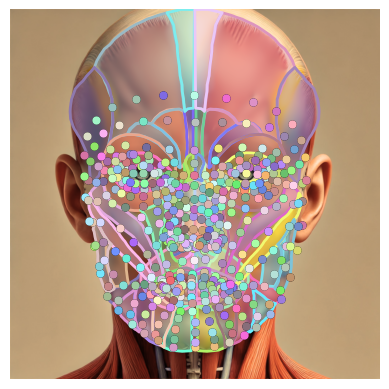

In [ ]:
display_annotations(image_path, coco_keypoints_norm_path, [mirrored_segments_path_normalized], [coco_keypoints_norm_path])

----
# Plot
